This file is meant to test changes to the noisy gates library downloaded in this folder offline

get API key here: ```https://cloud.ibm.com/iam/apikeys```



In [1]:
# Standard libraries
import numpy as np
import json
import os, sys, importlib
from typing import List
from dotenv import load_dotenv
import matplotlib.pyplot as plt

# Qiskit
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.controlflow import ControlFlowOp
from qiskit.result import marginal_counts
from qiskit.transpiler import CouplingMap, Layout
from qiskit_ibm_runtime import QiskitRuntimeService

from qiskit_ibm_runtime.fake_provider import FakeBrisbane
  # try other Fake*V2 if needed
from quantum_gates.utilities import DeviceParameters

# 0) Point to the *parent* of the package folder
LOCAL_QG_PATH = r"..\src"   # or r"C:\Users\npace\Desktop\quantum-gates\src"
LOCAL_QG_PATH = os.path.abspath(LOCAL_QG_PATH)

# 1) Put local src at the very front of sys.path
if LOCAL_QG_PATH in sys.path:
    sys.path.remove(LOCAL_QG_PATH)
sys.path.insert(0, LOCAL_QG_PATH)

# 2) Purge any cached copies of the package
for m in list(sys.modules):
    if m == "quantum_gates" or m.startswith("quantum_gates."):
        del sys.modules[m]

# 3) Invalidate import caches and import the local package
importlib.invalidate_caches()
import quantum_gates

print("Using quantum_gates from:", quantum_gates.__file__)

# Own library
from quantum_gates.utilities import fix_counts
from quantum_gates.simulators import MrAndersonSimulator
from quantum_gates.gates import standard_gates
from quantum_gates.circuits import EfficientCircuit, BinaryCircuit
from quantum_gates.utilities import DeviceParameters
from quantum_gates.utilities import setup_backend
    

Using quantum_gates from: c:\Users\npace\Desktop\quantum-gates\src\quantum_gates\__init__.py


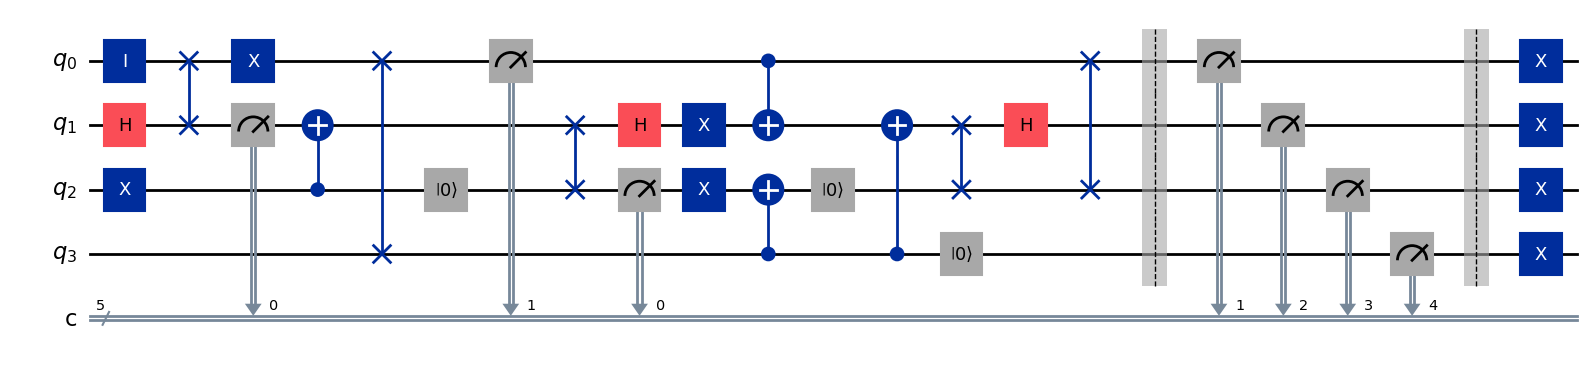

In [2]:
# --- 1. Define a circuit that makes SWAPs matter ---
N_q = 4
N_m = N_q+1  # number of measured qubits
qc = QuantumCircuit(N_q, N_m)
# Prepare |01>
qc.x(2)
# Apply Identity gates to introduce noise
qc.id(0)
qc.h(1)

# Apply SWAP
qc.swap(0, 1)
qc.measure(1,0)
qc.x(0)
#qc.barrier()  #
qc.cx(2, 1)

qc.reset(2)
qc.swap(2, 1)
qc.h(1)
#qc.barrier()  #
qc.measure(2,0)
qc.x(2)
#qc.barrier()  #
qc.swap(3, 0)
qc.cx(3, 2)
qc.reset(2)
qc.measure(0,1)
qc.x(1)
#qc.barrier()  #
qc.cx(0, 1)
qc.cx(3, 1)

qc.reset(3)
qc.swap(2, 1)
qc.h(1)
qc.swap(0, 2)
# Measure
qc.barrier()  #

qc.measure(range(N_q), range(1,N_m))
qc.barrier()  #
qc.x(range(N_q))  #


qc.draw('mpl')

In [3]:
# 1) Pick a fake backend
backend = FakeBrisbane()  # 127 qubits; change to another Fake*V2 if import fails

# 2) Use only N qubits
qubits_layout = list(range(N_q))

# 3) Load via YOUR class and save JSON next to the script
device_param = DeviceParameters(qubits_layout)
device_param.load_from_backend(backend)
device_param_lookup = device_param.__dict__()
#device_param.save_to_json("./")  # writes ./device_parameters.json
#print("Wrote ./device_parameters.json")

In [4]:

sim = MrAndersonSimulator(gates=standard_gates, CircuitClass=EfficientCircuit)

''' # For Noise free simulation
from quantum_gates.gates import NoiseFreeGates  
sim = MrAndersonSimulator(
    CircuitClass=EfficientCircuit 
'''

bit_flip_bool = True # turn on/off for readout noise

initial_psi = np.zeros(2**N_q)
initial_psi[0] = 1.0  # set |00...0⟩
initial_layout = list(range(N_q))  # logical qubit 0→physical 0, 1→1, etc.
shots = 200

In [5]:



needs_controlflow = any(isinstance(op.operation, ControlFlowOp) for op in qc.data)

t_circ = transpile(
    qc,
    backend,
    initial_layout=qubits_layout,
    seed_transpiler=42,
    **({} if needs_controlflow else {"scheduling_method": "asap"})
)

res  = sim.run( 
    t_qiskit_circ=t_circ, 
    psi0=initial_psi, 
    shots=shots, 
    device_param=device_param_lookup,
    nqubit=N_q,
    bit_flip_bool=bit_flip_bool,
    )

probs = res["probs"]
results = res["results"]
num_clbits = res["num_clbits"]
measured_statevetors = res["statevector_readout"]
mid_counts = res["mid_counts"]


#print("Mid-circuit measurement results", results)
print("statevectors of measures:", measured_statevetors)
print("Number of classical bits in circuit:", num_clbits)
print("Mid-circuit measurement counts:", mid_counts)

statevectors of measures: [array([ 6.62173014e-03-0.00230787j,  0.00000000e+00+0.j        ,
        3.57850317e-03-0.70325341j,  0.00000000e+00+0.j        ,
       -6.68103005e-03+0.00236763j,  0.00000000e+00+0.j        ,
        8.47625824e-05+0.71086034j,  0.00000000e+00+0.j        ,
        0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
        0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
        0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
        0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ]), array([ 0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
       -0.73758824+0.1153314j ,  0.        +0.j        ,
       -0.01008308-0.04002432j,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
       -0.11953382-0.65220013j,  0.        +0.j        ,
        0.02817874-0.02261096j,  0.        +0.j     

Post processing and plotting hists

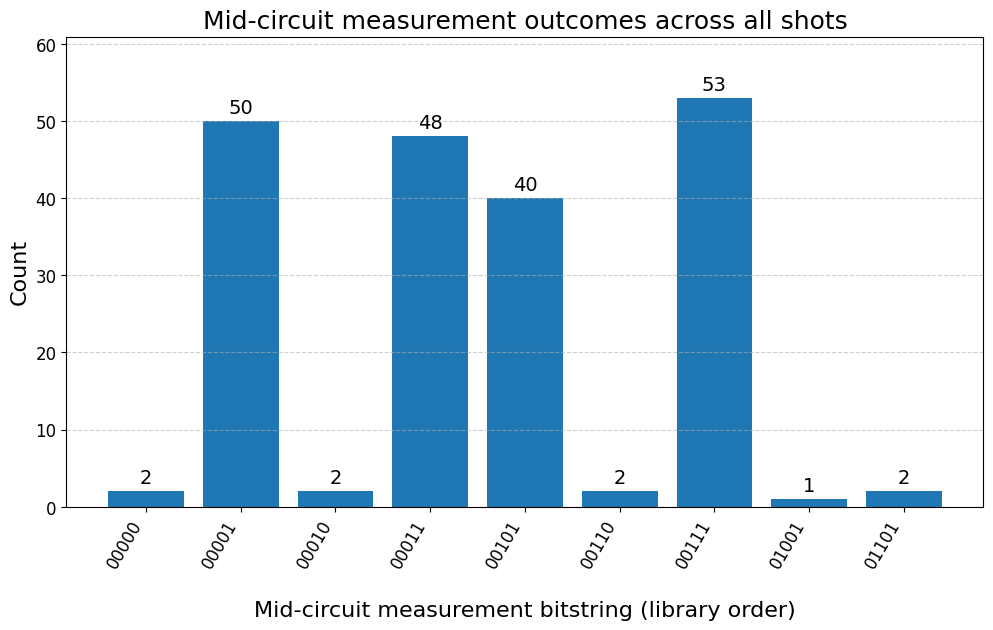

Mid-circuit measurement counts: {'00011': 48, '00001': 50, '00101': 40, '00111': 53, '00110': 2, '01101': 2, '00000': 2, '01001': 1, '00010': 2}


In [6]:

# --- Plot histogram ---
labels = sorted(mid_counts.keys())
values = [mid_counts[k] for k in labels]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color="#1f77b4")  # same default Aer blue

# Extend y-axis a bit to fit annotations
max_val = max(values)
plt.ylim(0, max_val * 1.15)

# Annotate bar tops
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.5, str(val),
             ha='center', va='bottom', fontsize=14, color="black")

plt.xlabel("\nMid-circuit measurement bitstring (library order)", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Mid-circuit measurement outcomes across all shots",fontsize=18)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.yticks(fontsize=12)
plt.xticks(rotation=60, ha="right", fontsize=12)   # tilt x-axis labels

plt.show()

# --- Optional printout ---
print("Mid-circuit measurement counts:", dict(mid_counts))

Modified Hist Plot of above 5% counts 

Filtered mid-circuit measurement counts

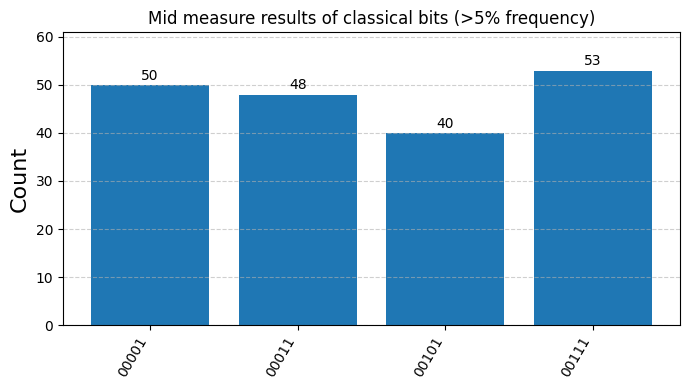

In [7]:
threshold = 0.05 * shots  # 5% cutoff

# --- Filter ---
filtered_counts = {k: v for k, v in mid_counts.items() if v >= threshold}

# --- Sort by bitstring (optional) ---
filtered_labels = list(sorted(filtered_counts.keys()))
filtered_values = [filtered_counts[k] for k in filtered_labels]

# --- Plot ---
plt.figure(figsize=(7, 4))
bars = plt.bar(filtered_labels, filtered_values, color="#1f77b4")  # same default Aer blue

# Extend y-axis a bit to fit annotations
max_val = max(filtered_values)
plt.ylim(0, max_val * 1.15)

# Annotate bar tops
for bar, val in zip(bars, filtered_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.5, str(val),
             ha='center', va='bottom', fontsize=10, color="black")

# Match Aer-style axes
plt.ylabel("Count", fontsize=16)
plt.xlabel("")  # Aer histograms usually skip x-axis label
plt.title("Mid measure results of classical bits (>5% frequency)", fontsize=12)
plt.xticks(rotation=60, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Tight layout to match Aer formatting
plt.tight_layout()
plt.show()

Probabilities Generated by Final Measures

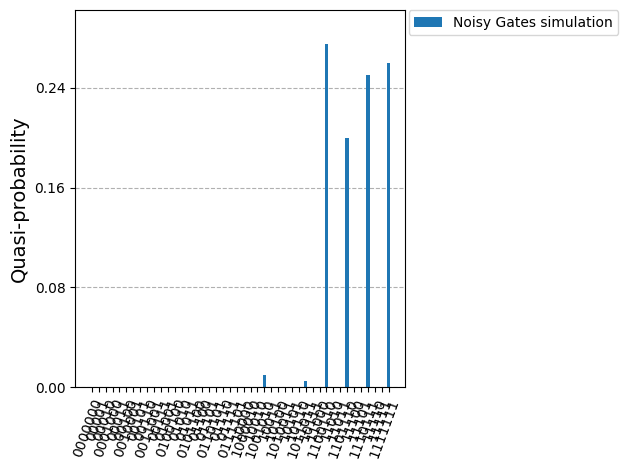

In [8]:
# Probabilities Generated by Final Measures
measured_qubit = N_m
counts_ng = fix_counts(probs, measured_qubit)
plot_histogram(counts_ng, bar_labels=False, legend=['Noisy Gates simulation'])

Comparison with AER

In [9]:
# Simulate with Aer
sim = AerSimulator()
t_qc = transpile(qc, sim)
result = sim.run(t_qc, shots=shots).result()
counts = result.get_counts()

Aer All clbits counts: {'00101': 47, '00001': 51, '00111': 48, '00011': 54}


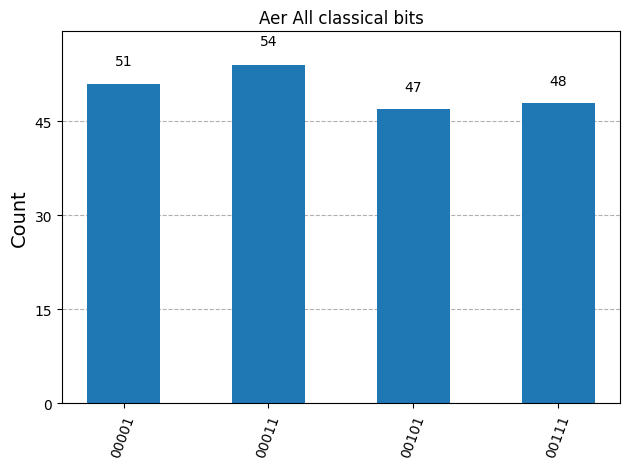

In [10]:
print("Aer All clbits counts:", counts)
plot_histogram(counts, title="Aer All classical bits")

Filtering Example

Truncated to final 2 bits: {'0101': 47, '0001': 51, '0111': 48, '0011': 54}


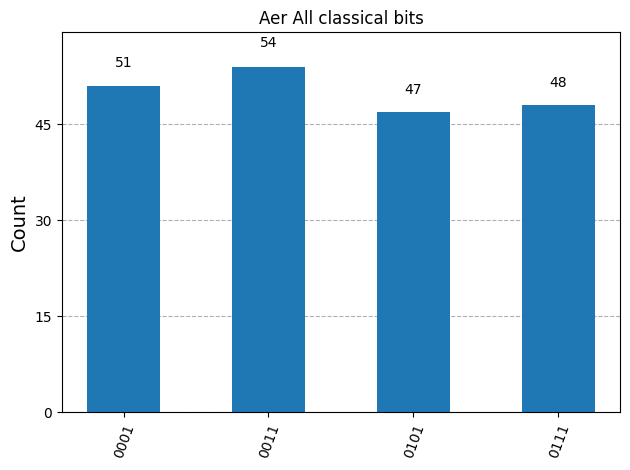

In [11]:
# Keep only the final measurement bits
final_counts = marginal_counts(counts, indices=range(N_q))

print("Truncated to final 2 bits:", final_counts)
plot_histogram(final_counts, title='Aer All classical bits')